In [28]:
#! pip install neuraloperator
import neuralop

y_pred =  [13.186 18.782 10.66  15.923 24.453  7.607 30.697 26.576 23.8   22.516
 21.005 17.467 26.899 20.175 20.769 18.721 13.432 17.355 20.446  9.821
 26.494  7.864 11.677 24.754 21.6   11.399  9.134 19.754 25.392 32.319
 13.389 21.639 27.13  16.831 18.688 23.779 17.085 15.038 28.326 33.429
 12.385 18.565 14.551 10.802 17.192 20.555 24.854 15.632 20.114 14.725
  8.385 10.927  7.638 18.616 19.227  9.449 14.326 18.428 32.45   7.445
 21.498 20.605 10.969 24.245 33.808 26.776 26.098 13.272  7.676 28.178
 16.994 25.243 17.706 19.393 15.806 32.046 10.682 19.59  30.622 32.007
 13.183 15.55  16.169 21.982 18.721 13.398 14.391 18.679 22.416 10.91
 32.167 24.354 16.774 24.388 15.948 28.754 28.517 18.929 26.646 21.768
 17.197 26.706 14.155  9.751 11.051 30.258 15.105]
y_test =  [13.8 19.2 11.1 16.2 19.   8.1 30.7 27.4 24.2 22.3 22.2 15.6 28.2 21.5
 20.  18.8 13.8 17.2 19.2 10.8 27.   8.7 12.3 25.1 22.2 11.2  9.5 20.
 25.1 31.8 13.6 21.7 27.4 18.1 17.9 22.9 16.8 15.2 29.1 33.1 13.2 16.3
 15.3 11

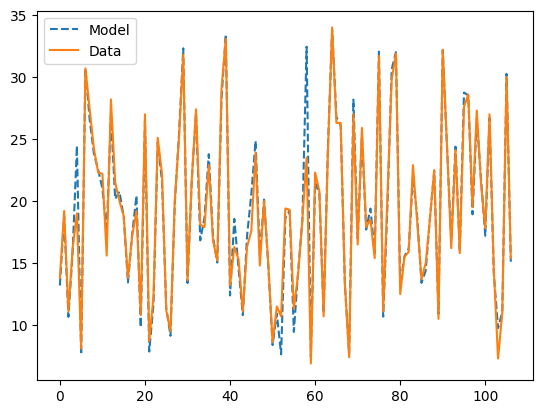

Mean Squared Error: 1.6739651775700923
R-squared: 0.9624043729482771

Feature Importances:
            Feature    Importance
1           MaxTemp  9.880333e-01
9       Humidity3pm  3.127006e-03
14          Temp9am  8.925124e-04
3       Evaporation  7.212436e-04
4          Sunshine  6.753963e-04
..              ...           ...
23  WindGustDir_NNE  1.668403e-06
64    WindDir3pm_SW  5.961809e-07
33  WindGustDir_WSW  2.025353e-07
34  WindGustDir_nan  1.181675e-18
68   WindDir3pm_nan  0.000000e+00

[69 rows x 2 columns]


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report


df = pd.read_csv('weather.csv')

# Convert categorical features to numerical
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})

# Identify the categorical columns you want to one-hot encode
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df[categorical_cols])

# Get the feature names for the new encoded columns
feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new DataFrame with the one-hot encoded data
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# Separate features (X) and target (y)
X = df_encoded.drop(columns = ['Temp3pm'])# all columns except the rain tmr
y = df_encoded['Temp3pm'] # last

# Handle missing values
X = X.dropna()
y = y.loc[X.index] # y only has rows corresponding to row indices of X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('y_pred = ' , y_pred)
print('y_test = ' , y_test.to_numpy())
plt.plot(y_pred, '--', label='Model')
plt.plot(y_test.to_numpy(), label='Data')
plt.legend()
plt.show()

# Evaluate the regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
# Get feature importances
importances = model.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Print the feature importances
print("\nFeature Importances:")
print(feature_importances)

In [14]:
import torch

In [19]:
dir(neuralop.data)

['__annotations__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'datasets',
 'transforms']

In [27]:
from neuralop.training import Trainer
from neuralop.models import FNO
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

# Dataset Preparation
class WeatherTensorDataset(Dataset):          # This class is a custom dataset loader that will load preprocessed
    def __init__(self, data_path):            # weather data (saved as a .pt file) into PyTorch’s data pipeline.
        self.samples = torch.load(data_path)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return {'x': input_tensor, 'y': target_tensor}  # (input, target)


# Load and clean the CSV file
df = pd.read_csv('data2022/accum_data.csv')
df = df.dropna()   # Drop rows with missing values

# Grid creation
times = sorted(df['valid_time'].unique()) # Get unique times

input_vars = ['u10', 'v10', 'surface_pressure', 'u10n', 'v10n']
output_var = 'surface_temperature'  # or choose a target variable

grids = []

# Process the data for each time step
for time in tqdm(times):   # tqdm(times) progress bar for visualization
    slice_df = df[df['valid_time'] == time] # Get data for the current time step

    lat_vals = sorted(slice_df['latitude'].unique()) # Unique lat
    lon_vals = sorted(slice_df['longitude'].unique()) # Unique long

    H = len(lat_vals) # Height (number of latitude values)
    W = len(lon_vals)  # Width (number of longitude values)

    # Build 2D grid for each input variable
    input_channels = []
    for var in input_vars:
        pivot = slice_df.pivot(index='latitude', columns='longitude', values=var)
        grid = pivot.to_numpy() # Creates a 2D grid using pandas
        input_channels.append(grid)

    # Build target grid
    target_pivot = slice_df.pivot(index='latitude', columns='longitude', values=output_var)
    target_grid = target_pivot.to_numpy()

    # Stack into tensors
    input_tensor = torch.tensor(np.stack(input_channels), dtype=torch.float32)  # Shape: [C, H, W]  (C is the # of input variables, H is the # of lat points, and W is the # of long points)
    target_tensor = torch.tensor(target_grid[np.newaxis, :, :], dtype=torch.float32)  # Shape: [1, H, W]

    grids.append((input_tensor, target_tensor))

# Save the dataset to a file
torch.save(grids, 'weather_dataset.pt')  # List of (input, target) pairs

# Dataset Splitting
full_dataset = WeatherTensorDataset('weather_dataset.pt')
train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model Setup
in_channels = 5 # # of input
out_channels = 1 # # of output

# Initialize the model
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=10, device=device)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}

# Train the model
trainer.train(train_loader, test_loaders, optimizer, scheduler)

100%|██████████| 1460/1460 [00:52<00:00, 27.88it/s]


{'train_err': 0.04927059527397258,
 'avg_loss': 0.012317648818493145,
 'avg_lasso_loss': None,
 'epoch_train_time': 17.6845276869999,
 'test_l2': tensor(0.0089)}